In [1]:
import graphviz 
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn import tree

import utils

from utils import local_data
from utils import window
from utils import Scale, give_error
from utils import smooth_signal
from utils import location_station, find_set_sunrise, find_set_sunset

%matplotlib inline
warnings.filterwarnings('ignore')

latter_size = 14
plt.rcParams['legend.fontsize'] = latter_size 
plt.rcParams['font.size'] = latter_size 
plt.rcParams['axes.labelsize'] = latter_size
plt.rcParams['xtick.labelsize'] = latter_size
plt.rcParams['ytick.labelsize'] = latter_size

In [2]:
df = pd.read_pickle('./data/sj2_analise.pkl')

In [3]:
df.head()

,vtec,vtec_dt,vtec_dt2,gvtec1,gvtec1_dt,gvtec2,gvtec2_dt,s4
2013-12-01 03:30:00,33.624428,-0.428246,-0.020502,-3.216613,0.002355,1.826065,1.991653,0.163334
2013-12-01 03:40:00,33.205025,-0.546589,-0.118343,-3.122300,0.130198,4.588494,2.530373,0.165397
2013-12-01 03:50:00,32.539631,-0.772594,-0.226005,-2.810556,0.280756,7.786990,2.862830,0.168683
2013-12-01 04:00:00,31.469337,-1.082859,-0.310265,-2.320938,0.399753,10.972091,2.894375,0.173552
2013-12-01 04:10:00,29.995466,-1.429647,-0.346788,-1.764129,0.443303,13.734955,2.621609,0.178917


### (1) Estimação de s4 com vtec

The scores for the k-fold crossvalidation was:
[-0.00307746 -0.00247765 -0.00298026 -0.00282674 -0.00320978 -0.0032597
 -0.00293339 -0.0028056  -0.003553   -0.00290541] 

O erro quadrático médio foi: 0.002727
O erro quadrático total foi: 3.133090
O maior erro por previsão foi: 0.394219
O erro relativo foi: 12.516414%
O número de verdadeiros negativos foi: 2773
O número de verdadeiros positivos foi: 118
O número de falsos negativos foi: 259
O número de falsos positivos foi: 450
O POD foi: 0.312997
O FAR foi: 0.792254
A ACC foi: 0.803056
O kappa foi: 0.059514

Error for the time series sample:
O erro quadrático médio foi: 0.008687
O erro quadrático total foi: 2.421553
O maior erro por previsão foi: 0.592276
O erro relativo foi: 15.438666%
O número de verdadeiros negativos foi: 531
O número de verdadeiros positivos foi: 25
O número de falsos negativos foi: 59
O número de falsos positivos foi: 60
O POD foi: 0.297619
O FAR foi: 0.705882
A ACC foi: 0.823704
O kappa foi: 0.072053


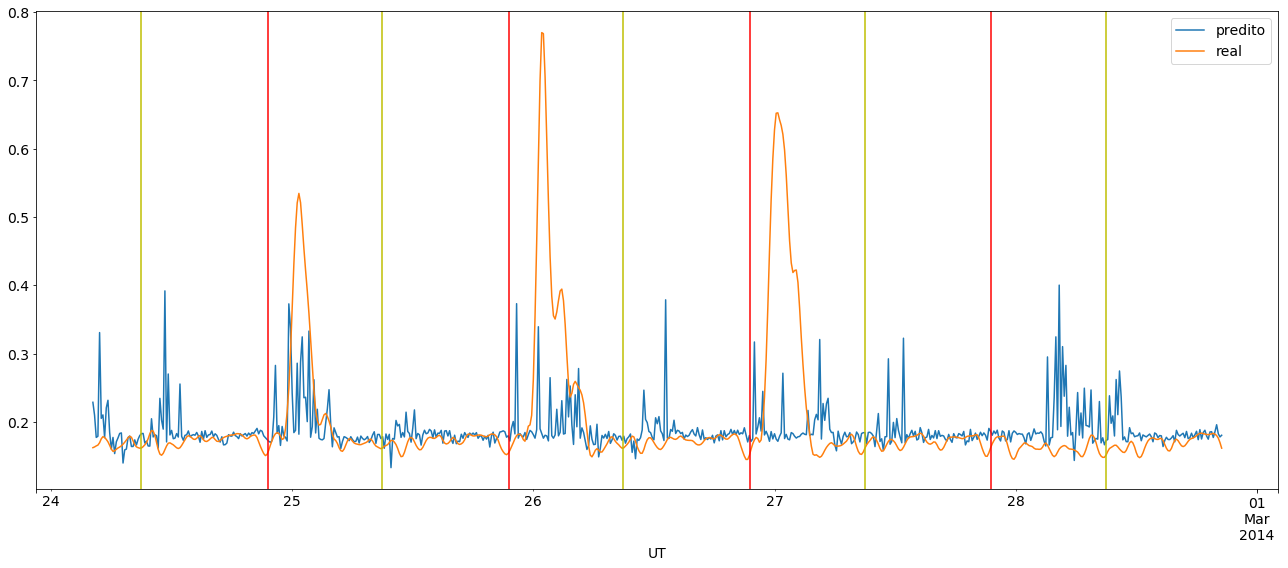

In [4]:
instances_set = ['vtec']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

# generate model, use k-fold crossvalidation and print scores
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predito'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predito'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(18, 8));

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.xlabel('UT')
plt.tight_layout()
plt.savefig('./images/regression_random_florest_1.eps', format='eps', dpi=1000)

### (2) Estimação de s4 com vtec, vtec_dt e vtec_dt2

The scores for the k-fold crossvalidation was:
[-0.00171922 -0.00162287 -0.00184045 -0.00233091 -0.00210236 -0.00242207
 -0.00205167 -0.00171813 -0.00194887 -0.00202441] 

O erro quadrático médio foi: 0.001850
O erro quadrático total foi: 2.580775
O maior erro por previsão foi: 0.384689
O erro relativo foi: 10.205708%
O número de verdadeiros negativos foi: 2769
O número de verdadeiros positivos foi: 243
O número de falsos negativos foi: 134
O número de falsos positivos foi: 454
O POD foi: 0.644562
O FAR foi: 0.651363
A ACC foi: 0.836667
O kappa foi: 0.037143

Error for the time series sample:
O erro quadrático médio foi: 0.006994
O erro quadrático total foi: 2.172727
O maior erro por previsão foi: 0.521741
O erro relativo foi: 16.649708%
O número de verdadeiros negativos foi: 488
O número de verdadeiros positivos foi: 60
O número de falsos negativos foi: 24
O número de falsos positivos foi: 103
O POD foi: 0.714286
O FAR foi: 0.631902
A ACC foi: 0.811852
O kappa foi: 0.039269


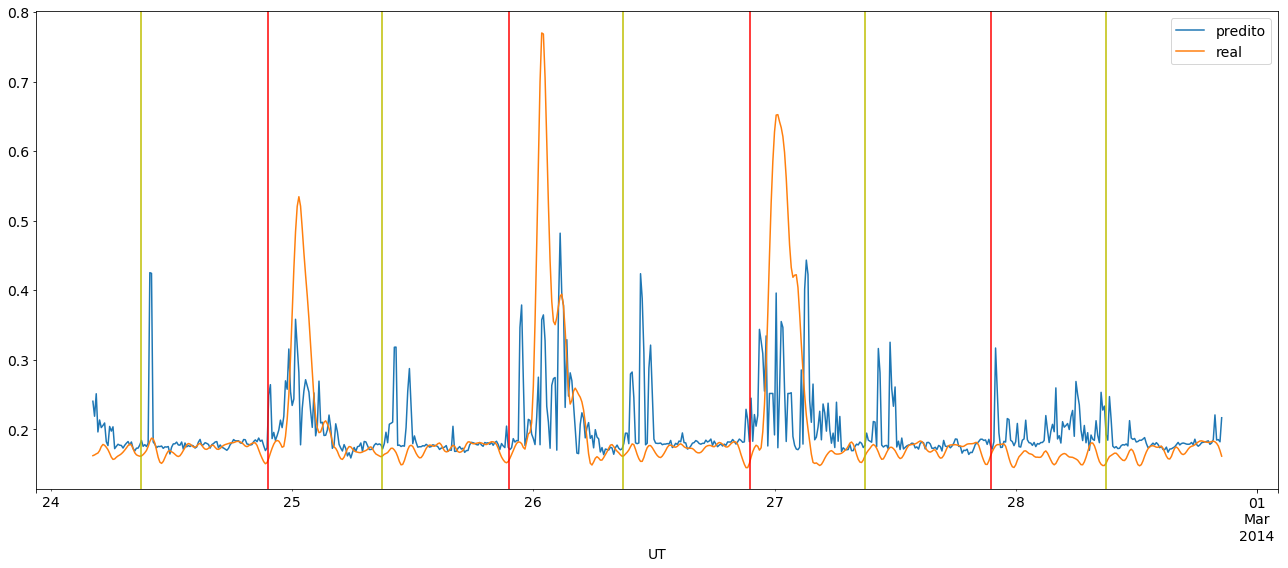

In [5]:
instances_set = ['vtec', 'vtec_dt', 'vtec_dt2']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

# generate model, use k-fold crossvalidation and print scores
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predito'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predito'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(18, 8));

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.xlabel('UT')
plt.tight_layout()
plt.savefig('./images/regression_random_florest_2.eps', format='eps', dpi=1000)

### (3) Estimação de S4 com vtec, gvtec1 e gvtec2

The scores for the k-fold crossvalidation was:
[-0.00153298 -0.00136069 -0.00157705 -0.00177871 -0.0015203  -0.00156118
 -0.00174714 -0.00144623 -0.00154942 -0.00156954] 

O erro quadrático médio foi: 0.001511
O erro quadrático total foi: 2.332680
O maior erro por previsão foi: 0.360637
O erro relativo foi: 8.863114%
O número de verdadeiros negativos foi: 2911
O número de verdadeiros positivos foi: 260
O número de falsos negativos foi: 117
O número de falsos positivos foi: 312
O POD foi: 0.689655
O FAR foi: 0.545455
A ACC foi: 0.880833
O kappa foi: 0.032539

Error for the time series sample:
O erro quadrático médio foi: 0.006833
O erro quadrático total foi: 2.147693
O maior erro por previsão foi: 0.547344
O erro relativo foi: 15.354458%
O número de verdadeiros negativos foi: 524
O número de verdadeiros positivos foi: 57
O número de falsos negativos foi: 27
O número de falsos positivos foi: 67
O POD foi: 0.678571
O FAR foi: 0.540323
A ACC foi: 0.860741
O kappa foi: 0.039434


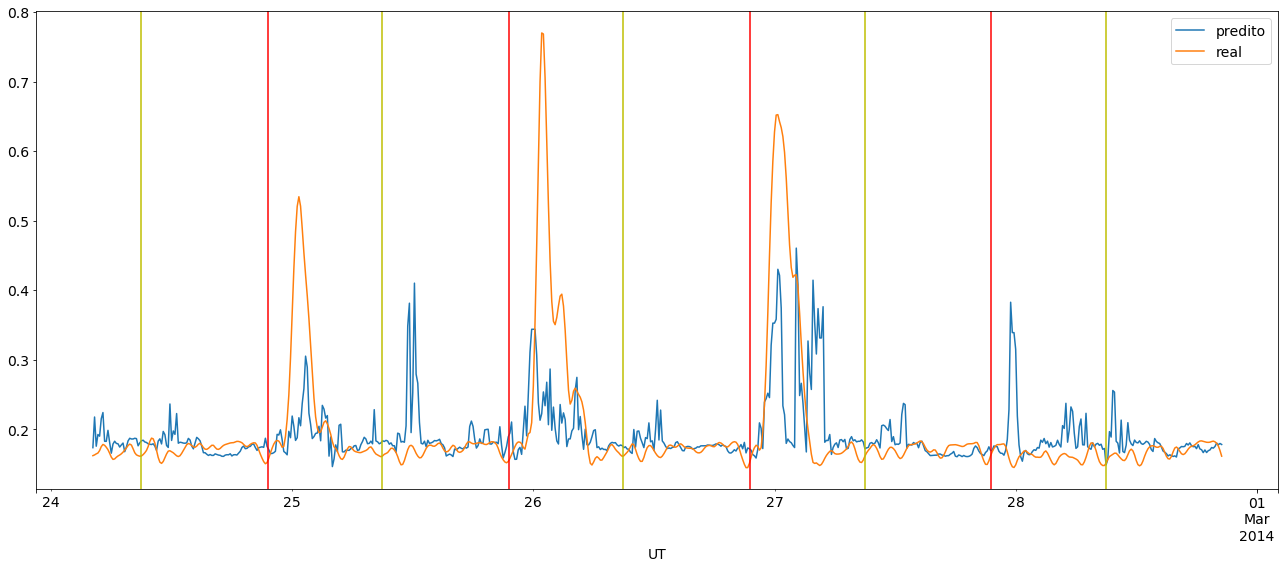

In [6]:
instances_set = ['vtec', 'gvtec1', 'gvtec2']
scaler = StandardScaler()
scaler.fit(X=df[instances_set].values) 
X = scaler.transform(X=df[instances_set].values)
y = df['s4'].values

X_train, X_test, y_train, y_test = train_test_split(X[0:12000], y[0:12000], test_size=0.30, random_state=42)
index = df.index.values[12000:12772]

# generate model, use k-fold crossvalidation and print scores
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_mean_squared_error')
print('The scores for the k-fold crossvalidation was:')
print(scores, '\n')

# generate final model, and avaliate a test set
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
give_error(y_test, y_predict);
print()

# use the final model to avaliate the error in a sample of the time series
df_aux = pd.DataFrame(index=index)
df_aux['predito'] = model.predict(X[12000:12772])
df_aux['real'] = y[12000:12772]

print('Error for the time series sample:')
give_error(df_aux['real'].values, df_aux['predito'].values);

# plot the time series predict against the real values
ax = df_aux.plot(figsize=(18, 8));

lat, long = location_station('sj2')
set_of_sunrise = find_set_sunrise(df_aux, lat, long)
set_of_sunset = find_set_sunset(df_aux, lat, long)
for i in set_of_sunrise:
    ax.axvline(x=i, color='y')
for i in set_of_sunset[0:-1]:
    ax.axvline(x=i, color='r')

plt.xlabel('UT')
plt.tight_layout()
plt.savefig('./images/regression_random_florest_3.eps', format='eps', dpi=1000)